The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


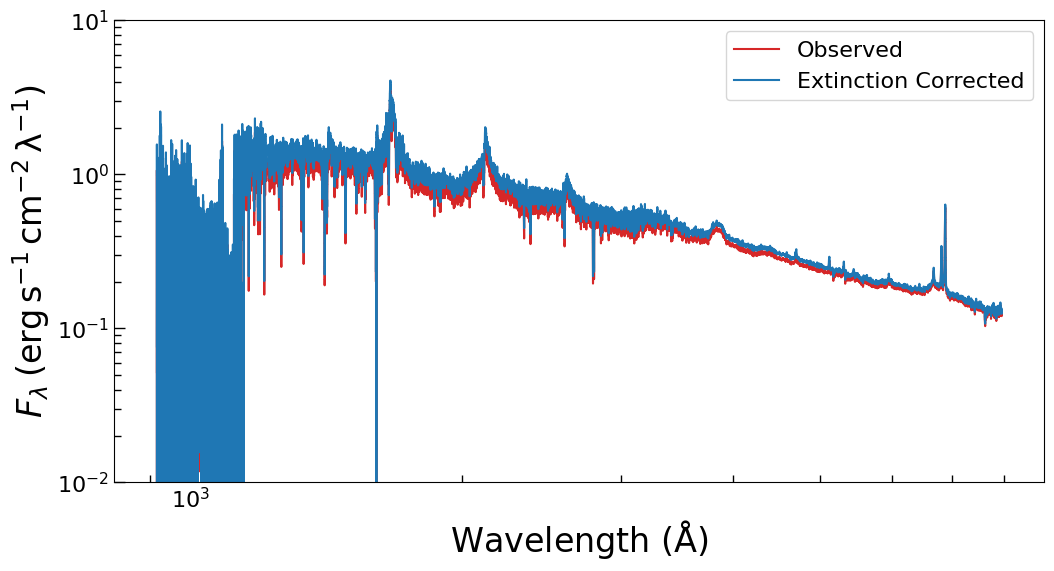

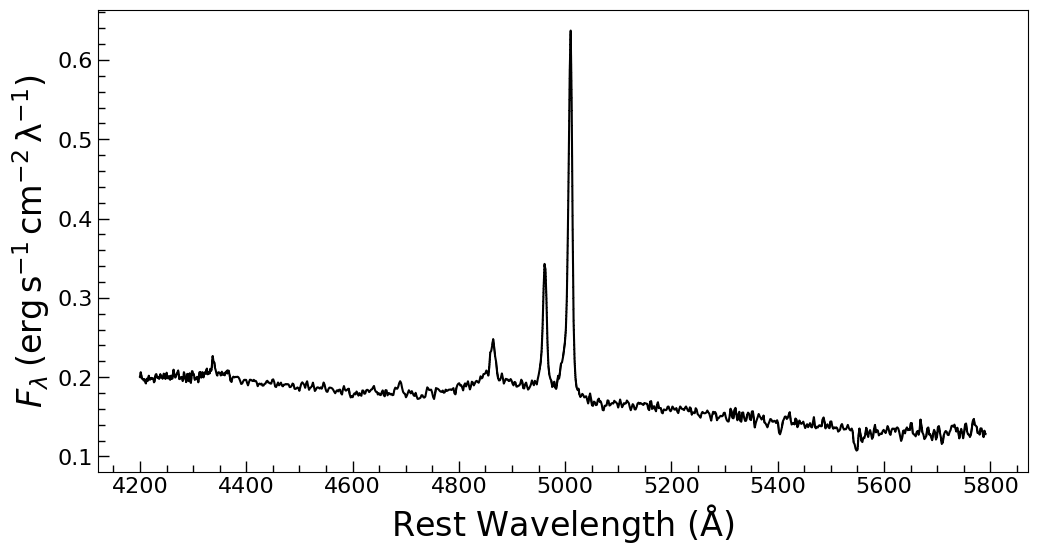

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('3c351sed.fit')  #---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.062    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.01, 10)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.373 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 5800          #------------------波长范围
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()


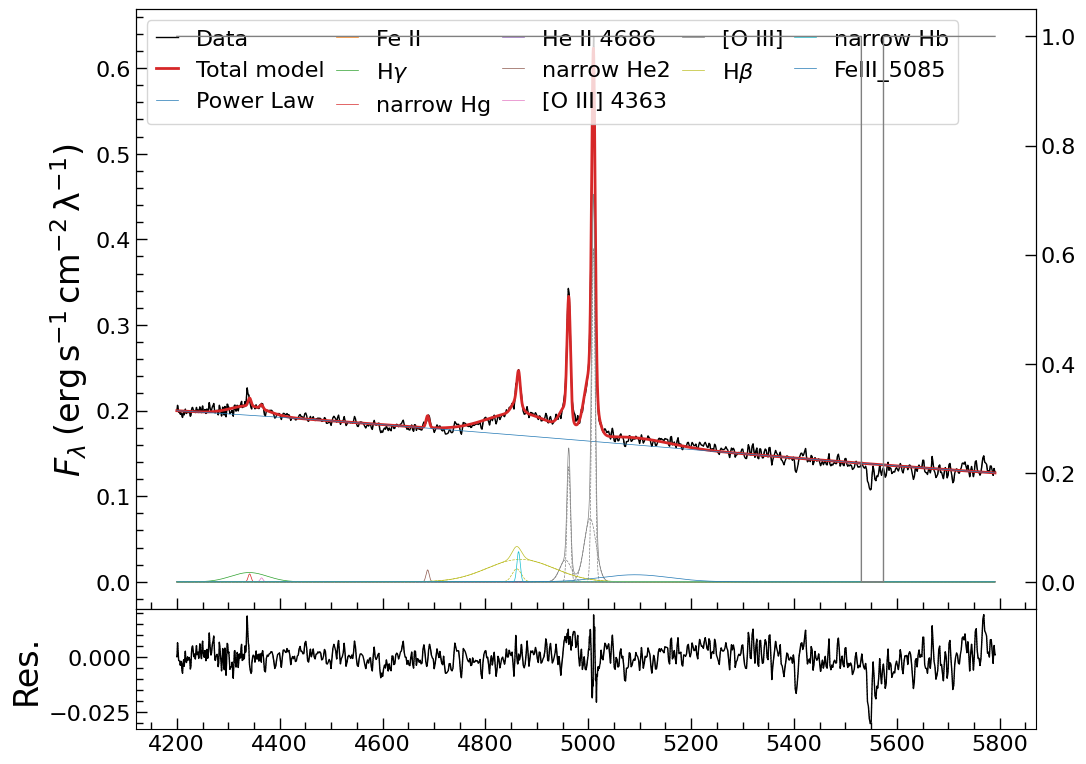

<PowerLaw1D(amplitude=0.35602639, x_0=5000., alpha=-1.50872973, name='Power Law')>
<IronTemplate(amplitude=0., stddev=10723., z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.01608651, dv_c=94.52991887, sigma_c=2437.37710462, wavec=4340., name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.01371094, dv=105.87682019, sigma=199.19233382, wavec=4340., name='narrow Hg')>
<Line_MultiGauss(amp_c=0., dv_c=500., sigma_c=809.98789578, wavec=4686., name='He II 4686')>
<Line_Gaussian(amplitude=0.0251588, dv=105.87682019, sigma=199.19233382, wavec=4686., name='narrow He2')>
<Line_Gaussian(amplitude=0.00699474, dv=105.87682019, sigma=199.19233382, wavec=4363.21, name='[O III] 4363')>
<Line_MultiGauss_doublet(amp_c0=0.84761935, amp_c1=0.28443602, dv_c=105.87682019, sigma_c=199.19233382, wavec0=5008.239, wavec1=4960.295, amp_w0=0.18948798, dv_w0=-379.25308839, sigma_w0=683.20727663, name='[O III]')>
<Line_MultiGauss(amp_c=0.05255879, dv_c=500., sigma_c=4000., wavec=4862.721, amp_w0=0.57494705, dv_w0=-608.309

In [6]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order

pl = models.PowerLaw1D(amplitude=0.4443, x_0=5000., alpha=2.2, fixed={'x_0': True},name='Power Law') #,'amplitude':True,'alpha':True
iron = sagan.IronTemplate(amplitude=0.00, stddev=10723, z=0., name='Fe II',fixed={'amplitude':True,'stddev':True,'z':True})#fixed={'amplitude':True,'stddev':True,'z':True}

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.018, dv_c=-420, sigma_c=3500, 
                             wavec=4340, name=label_dict['Hgamma'],bounds=bounds)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=500, sigma_c=810, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.06, dv_c=500, sigma_c=3500, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.59, dv_w0=-600, sigma_w0=570,bounds=bounds)

line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.38, amp_c1=0.14, dv_c=100, sigma_c=200, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.2, dv_w0=-320, sigma_w0=700)

n_hg = sagan.Line_Gaussian(amplitude=0.02, wavec=4340, name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.0056, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he2 = sagan.Line_Gaussian(amplitude=0.029, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_hb = sagan.Line_Gaussian(amplitude=0.086, wavec=wave_dict['Hbeta'], name=f'narrow Hb')

line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_hb  =  b_hb + n_hb

n_fe6_5146 = sagan.Line_Gaussian(amplitude=0.012, wavec=wave_dict['FeVI_5146'], name=f'[Fe VI] 5146')
n_fe7_5159 = sagan.Line_Gaussian(amplitude=0.005, wavec=wave_dict['FeVII_5159'], name=f'[Fe VII] 5159')
n_fe6_5176 = sagan.Line_Gaussian(amplitude=0.0076, wavec=wave_dict['FeVI_5176'], name=f'[Fe VI] 5176')


b_fe3_5085= sagan.Line_MultiGauss(n_components=1, amp_c=0.012, dv_c=500, sigma_c=3810,wavec=5085, name='FeIII_5085',bounds=bounds)

m_init = (pl + iron +line_hg+ line_he2 + n_o3_4363+line_o3 + line_hb+b_fe3_5085)*poly
#+line_hg+ line_he2 + n_o3_4363+line_o3 + line_hb  + n_ar4_4740+b_fe3_5085

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c



for line in [n_hb, n_hg, n_he2, n_o3_4363 ]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
#fltr1 = (wave_use > 4769) & (wave_use < 4893)
#fltr2 = (wave_use > 4282) & (wave_use < 4400)
fltr3 = (wave_use > 5531) & (wave_use < 5574)
fltr11= (wave_use > 4260) & (wave_use < 4430)
fltr12= (wave_use > 4770) & (wave_use < 5080)
fltr13= (wave_use > 5550) & (wave_use < 6050)

#weights[fltr1] = 0.0
#weights[fltr2] = 0.0
weights[fltr3] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())